In [ ]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
from sklearn.decomposition import PCA

Firstly, we read the input (frequency change by years) abd put them in a list

In [2]:
# load Input data and normalize
dir = '../result/HumanH3N2_NA_classified.csv'
def cal_frechg(input,sites):
    NA_df = pd.read_csv(input)
    DF_ls = []
    Mut_ls = []
    for i in sites:
        i_df = NA_df[NA_df['pos']==i]
        mut_set = list(set(i_df.charge))
        for mut in mut_set:
            df = i_df[i_df.charge==mut]
            df.loc[:,'change'] =df.freq-df.freq.shift(1)
            df = df.loc[:, ["year", "change"]]
            df.set_index("year",inplace=True)
            # set the date columns as index
            df.sort_index(inplace=True)
            df=df.replace(np.nan, 0)
            DF_ls.append(df)
            Mut_ls.append(mut)
    return DF_ls,Mut_ls
sites = [328,329,344,367,368,369,370]
df_ls,mut_ls = cal_frechg(dir,sites)
print(df_ls)
print(mut_ls)

[        change
year          
1968  0.000000
1969 -0.021505
1970  0.000000
1971  0.000000
1972  0.000000
1973  0.100000
1974  0.233333
1975 -0.033333
1976 -0.241176
1977  0.869748
1978  0.071429
1979  0.000000
1980  0.000000
1981  0.000000
1982  0.000000
1983  0.000000
1984  0.000000
1985  0.000000
1986  0.000000
1987  0.000000
1988  0.000000
1989  0.000000
1990  0.000000
1991  0.000000
1992 -0.029412
1993  0.029412
1994  0.000000
1995  0.000000
1996  0.000000
1997  0.000000
1998  0.000000
1999 -0.005988
2000  0.005988
2001  0.000000
2002  0.000000
2003  0.000000
2004  0.000000
2005 -0.002326
2006  0.002326
2007  0.000000
2008  0.000000
2009 -0.000792
2010  0.000021
2011 -0.000274
2012  0.000687
2013 -0.000553
2014 -0.000334
2015  0.000105
2016 -0.003174
2017  0.002461
2018  0.001376
2019  0.000113
2020 -0.001305,         change
year          
1968  0.000000
1969  0.021505
1970  0.000000
1971  0.000000
1972  0.000000
1973 -0.100000
1974 -0.233333
1975  0.033333
1976  0.241176
1977 -0.

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

           peak_magnitude resi aa
peak_year                        
1974             0.233333  328  +
1976            -0.241176  328  +
1977             0.869748  328  +
1974            -0.233333  328  n
1976             0.241176  328  n
1977            -0.869748  328  n
1970             0.833333  329  n
1970            -0.833333  329  -
1995            -0.613999  344  +
2019             0.625825  344  +
1995             0.627512  344  -
2019            -0.625647  344  -
1972             0.750000  368  -
1972            -0.750000  368  +
1995             0.640333  369  +
2010            -0.833078  369  +
2010             0.832329  369  n
1995            -0.640333  369  -
   peak_year  peak_magnitude resi aa
0       1974        0.233333  328  +
1       1977        0.869748  328  +
2       1976       -0.241176  328  +


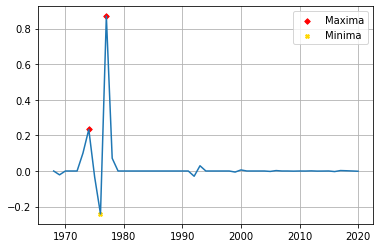

In [3]:
def PeakPoint(df_ls,mut_ls):
    DF = pd.DataFrame()
    for i, df in enumerate(df_ls):
        x=df.index.values
        y=df.change.values
        #Find peaks
        peaks = find_peaks(y, height = 0.05, threshold = 0.01, distance = 1)
        height = y[peaks[0]] #list of the heights of the peaks
        peak_pos = x[peaks[0]] #list of the peaks positions

        #Finding the minima
        y2 = y*-1
        minima = find_peaks(y2,height = 0.05, threshold = 0.01, distance = 1)
        min_pos = x[minima[0]] #list of the minima positions
        min_height = y2[minima[0]] #list of the mirrored minima heights
        year=np.concatenate((peak_pos,min_pos))
        val=np.concatenate((height,min_height*-1))
        df = pd.DataFrame()
        df['peak_year']=year
        df['peak_magnitude']=val
        df['resi']=mut_ls[i][:-1]
        df['aa']=mut_ls[i][-1]
        df.set_index("peak_year",inplace=True)
        # set the date columns as index
        df.sort_index(inplace=True)
        DF=DF.append(df)
    return DF
DF = PeakPoint(df_ls,mut_ls)
print(DF)
df = df_ls[0]
x=df.index.values
y=df.change.values

#Find peaks
peaks = find_peaks(y, height = 0.05, threshold = 0.01, distance = 1)
height = y[peaks[0]] #list of the heights of the peaks
peak_pos = x[peaks[0]] #list of the peaks positions

#Finding the minima
y2 = y*-1
minima = find_peaks(y2,height = 0.05, threshold = 0.01, distance = 1)
min_pos = x[minima[0]] #list of the minima positions
min_height = y2[minima[0]] #list of the mirrored minima heights
year=np.concatenate((peak_pos,min_pos))
val=np.concatenate((height,min_height*-1))
df = pd.DataFrame()
df['peak_year']=year
df['peak_magnitude']=val
df['resi']=mut_ls[0][:-1]
df['aa']=mut_ls[0][-1]

print(df)
#Plotting
fig = plt.figure()
ax = fig.subplots()
ax.plot(x,y)
ax.scatter(peak_pos, height, color = 'r', s = 15, marker = 'D', label = 'Maxima')
ax.scatter(min_pos, min_height*-1, color = 'gold', s = 15, marker = 'X', label = 'Minima')
ax.legend()
ax.grid()
plt.show()

In [4]:
#compare the peak distance(year) for different residues
resi=[328,329,344,367,368,369,370]
compare_ls=itertools.combinations(resi,2)
Compare_DF=pd.DataFrame(columns=["peak_1_year","peak_2_year","peak_1_magnitude","peak_2_magnitude","peak_1_resi","peak_2_resi","peak_1_aa","peak_2_aa","inter_peak_distance","inter_peak_class"])
for pair in compare_ls:
    i=pair[0]
    j=pair[1]
    i_df = DF[DF['resi']==str(i)]
    j_df = DF[DF['resi']==str(j)]
    for year_i, row_i in i_df.iterrows():
        peak_1_year=year_i
        peak_1_magnitude=row_i['peak_magnitude']
        peak_1_resi=row_i['resi']
        peak_1_aa=row_i['aa']
        peak_1='+'if peak_1_magnitude>0 else '-'
        for year_j, row_j in j_df.iterrows():
            peak_2_year=year_j
            peak_2_magnitude=row_j['peak_magnitude']
            peak_2_resi=row_j['resi']
            peak_2_aa=row_j['aa']
            peak_2='+'if peak_2_magnitude>0 else '-'
            inter_peak_distance=abs(peak_1_year-peak_2_year)
            inter_ppeak_class=peak_1+peak_2
            #add to dataframe
            add_row=[peak_1_year,peak_2_year,peak_1_magnitude,peak_2_magnitude,peak_1_resi,peak_2_resi,peak_1_aa,peak_2_aa,inter_peak_distance,inter_ppeak_class]
            add_series = pd.Series(add_row, index = Compare_DF.columns)
            Compare_DF = Compare_DF.append(add_series,ignore_index=True)
print(Compare_DF)
Compare_DF.to_csv('../result/compare_peak.csv')

    peak_1_year peak_2_year  peak_1_magnitude  peak_2_magnitude peak_1_resi  \
0          1974        1970          0.233333          0.833333         328   
1          1974        1970          0.233333         -0.833333         328   
2          1976        1970         -0.241176          0.833333         328   
3          1976        1970         -0.241176         -0.833333         328   
4          1977        1970          0.869748          0.833333         328   
..          ...         ...               ...               ...         ...   
119        1972        1995          0.750000         -0.640333         368   
120        1972        1995         -0.750000          0.640333         368   
121        1972        2010         -0.750000         -0.833078         368   
122        1972        2010         -0.750000          0.832329         368   
123        1972        1995         -0.750000         -0.640333         368   

    peak_2_resi peak_1_aa peak_2_aa inter_peak_dist

In [5]:
#filter out distance > 5 year
Compare_DF=Compare_DF[Compare_DF.inter_peak_distance >5]
print(Compare_DF)

    peak_1_year peak_2_year  peak_1_magnitude  peak_2_magnitude peak_1_resi  \
2          1976        1970         -0.241176          0.833333         328   
3          1976        1970         -0.241176         -0.833333         328   
4          1977        1970          0.869748          0.833333         328   
5          1977        1970          0.869748         -0.833333         328   
8          1976        1970          0.241176          0.833333         328   
..          ...         ...               ...               ...         ...   
119        1972        1995          0.750000         -0.640333         368   
120        1972        1995         -0.750000          0.640333         368   
121        1972        2010         -0.750000         -0.833078         368   
122        1972        2010         -0.750000          0.832329         368   
123        1972        1995         -0.750000         -0.640333         368   

    peak_2_resi peak_1_aa peak_2_aa inter_peak_dist

In [6]:
pos_DF1=Compare_DF[Compare_DF['inter_peak_class']=='++']
pos_DF2=Compare_DF[Compare_DF['inter_peak_class']=='--']
pos_DF=pd.concat([pos_DF1,pos_DF2])
pos_DF.loc[:,'EPI_ID']=pos_DF['peak_1_aa']+pos_DF['peak_1_resi']+'/'+pos_DF['peak_2_aa']+pos_DF['peak_2_resi']
mut_id=list(set(pos_DF.EPI_ID))
epi_ls=[]
for x in mut_id:
    pos_DF_x = pos_DF[pos_DF.EPI_ID==x]
    pos_DF_x.loc[:,'exp_distance']=np.exp(-1*pos_DF_x['inter_peak_distance'].astype('float'))
    epi=pos_DF_x.exp_distance.sum()
    epi_ls.append(epi)
natural_df = pd.DataFrame({'pair':mut_id,'Coevol_S':epi_ls})
print(natural_df)

         pair      Coevol_S
0   +328/-344  1.598824e-08
1   -344/-369  3.775135e-11
2   -344/n369  3.059023e-07
3   +328/n329  9.118820e-04
4   -329/+344  1.388794e-11
5   +328/-369  5.602796e-09
6   n329/n369  4.248354e-18
7   n328/-369  1.598824e-08
8   -329/-369  1.388794e-11
9   -329/-344  5.242886e-22
10  +368/-369  1.026188e-10
11  +344/+369  3.059401e-07
12  n329/+369  1.388794e-11
13  -344/-368  1.026188e-10
14  +328/-329  2.478752e-03
15  +344/-368  3.873998e-21
16  -368/n369  3.139133e-17
17  n328/+369  5.602801e-09
18  n328/n329  2.478752e-03
19  n328/+344  1.598824e-08
20  +328/+344  5.602796e-09
21  n328/n369  1.713908e-15
22  -329/+369  4.248354e-18
23  n328/-329  9.118820e-04
24  +328/+369  1.598824e-08
25  -344/+368  3.873998e-21
26  n329/-344  1.388794e-11
27  +368/+369  3.139133e-17
28  +344/n369  1.234098e-04
29  n328/-344  5.602796e-09
30  n329/+344  5.242886e-22
31  +344/+368  1.026188e-10
32  -368/+369  1.026188e-10
33  -344/+369  1.234098e-04
34  +328/n369  4.890

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
neg_DF1=Compare_DF[(Compare_DF['inter_peak_class']=='-+')]
neg_DF2=Compare_DF[(Compare_DF['inter_peak_class']=='+-')]
neg_DF=pd.concat([neg_DF1,neg_DF2])
neg_DF.loc[:,'EPI_ID']=neg_DF['peak_1_aa']+neg_DF['peak_1_resi']+'/'+neg_DF['peak_2_aa']+neg_DF['peak_2_resi']
mut_id=list(set(neg_DF.EPI_ID))
epi_ls=[]
for x in mut_id:
    neg_DF_x = neg_DF[neg_DF.EPI_ID==x]
    neg_DF_x.loc[:,'exp_distance']=-1*np.exp(-1*neg_DF_x['inter_peak_distance'].astype('float'))
    epi=neg_DF_x.exp_distance.sum()
    epi_ls.append(epi)
natural_df2 = pd.DataFrame({'pair':mut_id,'Coevol_S':epi_ls})

natural_df = pd.concat([natural_df,natural_df2])
print(natural_df)
natural_df=natural_df.groupby('pair').sum()
print(natural_df)

         pair      Coevol_S
0   +328/-344  1.598824e-08
1   -344/-369  3.775135e-11
2   -344/n369  3.059023e-07
3   +328/n329  9.118820e-04
4   -329/+344  1.388794e-11
..        ...           ...
30  n329/+344 -1.388794e-11
31  +344/+368 -3.873998e-21
32  -368/+369 -3.139133e-17
33  -344/+369 -3.059401e-07
34  +328/n369 -1.713908e-15

[70 rows x 2 columns]
               Coevol_S
pair                   
+328/+344 -1.038544e-08
+328/+369  1.038544e-08
+328/-329  1.566870e-03
+328/-344  1.038544e-08
+328/-369 -1.038544e-08
+328/n329 -1.566870e-03
+328/n369  3.176930e-15
+344/+368  1.026188e-10
+344/+369 -1.231039e-04
+344/-368 -1.026188e-10
+344/-369 -3.775135e-11
+344/n369  1.231039e-04
+368/+369 -1.026188e-10
+368/-369  1.026188e-10
+368/n369 -3.139133e-17
-329/+344  1.388794e-11
-329/+369 -1.388794e-11
-329/-344 -1.388794e-11
-329/-369  1.388794e-11
-329/n369 -4.248354e-18
-344/+368 -1.026188e-10
-344/+369  1.231039e-04
-344/-368  1.026188e-10
-344/-369  3.775135e-11
-344/n369 -1.2310

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
natural_df.to_csv('../result/Coevols_>5.csv')